In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [3]:
sp500.index = pd.to_datetime(sp500.index)

In [11]:
sp500.tail()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2024-04-02 00:00:00-04:00,5204.290039,5208.339844,5184.049805,5205.810059,3886590000,5211.490234,1
2024-04-03 00:00:00-04:00,5194.370117,5228.750000,5194.370117,5211.490234,3703250000,5147.209961,0
2024-04-04 00:00:00-04:00,5244.049805,5256.589844,5146.060059,5147.209961,4075680000,5204.339844,1
2024-04-05 00:00:00-04:00,5158.950195,5222.180176,5157.209961,5204.339844,3386780000,5202.390137,0
2024-04-08 00:00:00-04:00,5211.370117,5219.569824,5197.350098,5202.390137,3278180000,NaN,0


<Axes: xlabel='Date'>

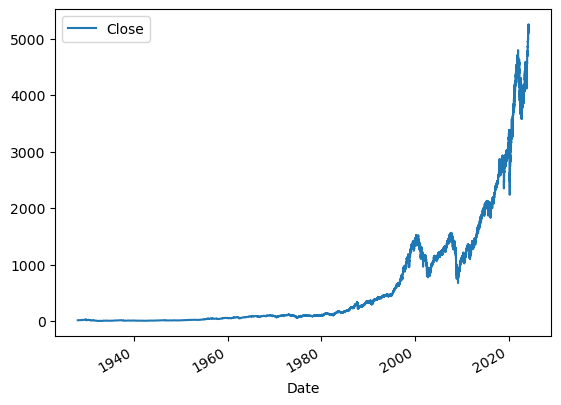

In [6]:
sp500.plot.line(y="Close", use_index=True)

In [7]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [8]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [9]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [10]:
sp500 = sp500.loc["2000-01-01":].copy()

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [13]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6666666666666666

<Axes: xlabel='Date'>

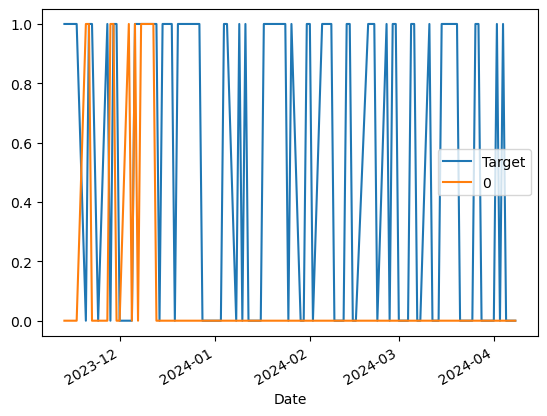

In [14]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [15]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [16]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [17]:
predictions = backtest(sp500, model, predictors)

In [18]:
predictions["Predictions"].value_counts()

Predictions
1    1842
0    1762
Name: count, dtype: int64

In [19]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5228013029315961

In [20]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.543563
0    0.456437
Name: count, dtype: float64

In [21]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [22]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [23]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2003-12-26 00:00:00-05:00,1094.040039,1098.469971,1094.040039,1095.890015,356070000,1109.479980,1,1.000845,1.0,1.002176,3.0,1.039354,34.0,1.137825,135.0,0.957328,485.0
2003-12-29 00:00:00-05:00,1095.890015,1109.479980,1095.890015,1109.479980,1058800000,1109.640015,1,1.006162,2.0,1.010755,4.0,1.050761,34.0,1.150837,135.0,0.969445,486.0
2003-12-30 00:00:00-05:00,1109.479980,1109.750000,1106.410034,1109.640015,1012600000,1111.920044,1,1.000072,2.0,1.007835,4.0,1.049591,34.0,1.150046,135.0,0.969833,486.0
2003-12-31 00:00:00-05:00,1109.640015,1112.560059,1106.209961,1111.920044,1027500000,1108.479980,0,1.001026,2.0,1.006997,4.0,1.050463,34.0,1.151439,136.0,0.972073,486.0
2004-01-02 00:00:00-05:00,1111.920044,1118.849976,1105.079956,1108.479980,1153200000,1122.219971,1,0.998451,1.0,1.001263,4.0,1.046073,33.0,1.147024,135.0,0.969348,485.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-02 00:00:00-04:00,5204.290039,5208.339844,5184.049805,5205.810059,3886590000,5211.490234,1,0.996367,0.0,0.995146,2.0,1.038192,34.0,1.147869,137.0,1.270375,532.0
2024-04-03 00:00:00-04:00,5194.370117,5228.750000,5194.370117,5211.490234,3703250000,5147.209961,0,1.000545,1.0,0.995931,3.0,1.037551,34.0,1.147997,138.0,1.271002,533.0
2024-04-04 00:00:00-04:00,5244.049805,5256.589844,5146.060059,5147.209961,4075680000,5204.339844,1,0.993795,1.0,0.987469,2.0,1.023451,33.0,1.132782,138.0,1.254621,532.0


In [24]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [25]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [26]:
predictions = backtest(sp500, model, new_predictors)

In [27]:
predictions["Predictions"].value_counts()

Predictions
0.0    2168
1.0     436
Name: count, dtype: int64

In [28]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5389908256880734

In [29]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.536482
0    0.463518
Name: count, dtype: float64

In [32]:
predictions.tail(50)

,Target,Predictions
Date,,
2024-01-26 00:00:00-05:00,1,0.0
2024-01-29 00:00:00-05:00,0,0.0
2024-01-30 00:00:00-05:00,0,0.0
2024-01-31 00:00:00-05:00,1,0.0
2024-02-01 00:00:00-05:00,1,0.0
2024-02-02 00:00:00-05:00,0,0.0
2024-02-05 00:00:00-05:00,1,0.0
2024-02-06 00:00:00-05:00,1,0.0
2024-02-07 00:00:00-05:00,1,0.0
